-------------------------------------------------------------

# Exercise 1.1

# Prepping data

In [2]:
# file imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.optimize import minimize as minimize
import time
import random
import itertools
import copy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge

In [3]:
# splitting data in train test and val set
def data_split(data, val = True):
    
    X = np.array(data.iloc[:,:2])
    y = np.array(data.iloc[:, 2])
    
    # train-val split 100% -> 70% - 30%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1) 
    
    if val == False:
        return X_train.T, X_val.T, y_train, y_val
    
    else:
    # val-test split 30% -> 15% - 15%
        X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=1)
        return X_train.T, X_test.T, X_val.T, y_train, y_test, y_val


data = pd.read_excel('dataPoints.xlsx')
random.seed(1696995)
X_train, X_test, X_val, y_train, y_test, y_val = data_split(data)

# Neural Network parent class

In [4]:
# common class for shallow neural newtworks with 1 output node
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.normal(0,1,(self.N, self.X.shape[0]))
        self.b = np.random.normal(0,1,(self.N,1))
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return np.mean(np.square(self.predict(X, w, b, v) - y)) 

## MLP child class

In [5]:
# Mlp inherits the general charectiristics of a shallow nn 
class Mlp(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def g(self, x):
        return (np.exp(2*self.sigma*x)-1)/(np.exp(2*self.sigma*x)+1)

    # forward propagation
    def predict(self, x, w, b, v):
        
        z = w @ x - b
        a = self.g(z)
        self.output = v @ a
        return self.output

    # derivative of activation function
    def g_der(self, x):
        return (4*self.sigma*np.exp(2*self.sigma*x))/np.square(np.exp(2*self.sigma*x)+1)
    
    def grad(self, params):
        
        w, b, v = self.separate(params)
        z = w @ self.X - b
        f_x = self.predict(self.X, w, b, v)
        
        self.dw = 2*self.rho*w + (1/self.X.shape[1]) * (((v.T @ (f_x-self.y)) * self.g_der(z)) @ X_train.T)
        self.db = 2*self.rho*b + ((v.T @ (f_x-self.y)) * self.g_der(z)) * -1
        self.db =(1/self.X.shape[1]) *  np.sum(self.db, axis = 1, keepdims = True)
        self.dv = 2*self.rho*v + (1/self.X.shape[1]) * (f_x-y_train) @ self.g(z).T
        

        return np.concatenate([array.reshape(-1) for array in [self.dw, self.db, self.dv]])
        
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = np.concatenate([array.reshape(-1) for array in [self.w, self.b, self.v]])
        
        print("begin training...", "\n")
        start = time.time()
        result =  minimize(self.loss, x0 = inits, method = self.method, jac = self.grad)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        # optimal parameters
        self.w, self.b, self.v = self.separate(result.x)
        
        return result.nfev, result.njev, result.nit, result.fun, result.jac, time_elapsed

## first run

In [6]:
nn = Mlp(X_train, y_train, N = 100, sigma = 5, rho = 10e-5, method = "BFGS")
func_eval, grad_eval, iterations, opt_fun, jacobian, time_elapsed = nn.optimize()
print("Training Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))#0.0007


begin training... 

      fun: 0.003788066742192087
 hess_inv: array([[ 180.03079389, -111.10601733,   -8.45475587, ...,  -20.57804671,
         -36.37191309,  -12.84624078],
       [-111.10601733,  355.188851  ,   18.35217112, ...,   59.27378509,
          56.09118919,   21.31582531],
       [  -8.45475587,   18.35217112,   85.64396318, ...,   -7.0478743 ,
           8.1015861 ,   -2.50949752],
       ...,
       [ -20.57804671,   59.27378509,   -7.0478743 , ...,  319.93386601,
           6.21796817,   12.26475913],
       [ -36.37191309,   56.09118919,    8.1015861 , ...,    6.21796817,
         158.53872953,   34.71684599],
       [ -12.84624078,   21.31582531,   -2.50949752, ...,   12.26475913,
          34.71684599,  108.42118262]])
      jac: array([ 9.87775871e-07, -1.56928956e-06, -1.40728466e-06,  4.46157514e-08,
        9.32101587e-08,  5.88518075e-08, -1.55461874e-07,  4.85541987e-07,
       -3.81028466e-06, -2.51349071e-06,  8.90428897e-06, -3.85740368e-06,
       -1.950258

In [7]:
np.linalg.norm(jacobian)

4.849825136255105e-05

In [21]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure(figsize = [20,10])
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(-1, 1, 200)
    x2 = np.linspace(-2, 2, 200)
    X1, X2 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.w, nn.b, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    


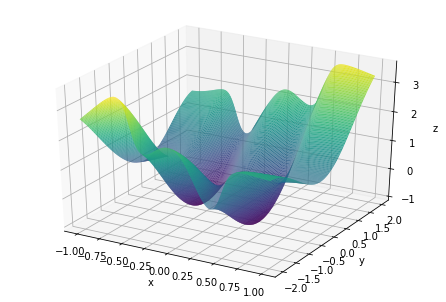

In [8]:
plot(nn)

In [0]:
#
# Grid Search (takes ~2 hours) -------> (50, 5, 0.0001, 'CG') error on val of ~0.00022
#

"""
param_grid = {"N" : [10, 20, 50], "sigma" : [1, 2, 5], "rho" : [10e-4, 10e-5], "method" : ["BFGS", "CG"]}

results = []
combinations = list(itertools.product(*param_grid.values()))
for comb in tqdm_notebook(combinations):
    
    print("current combination :", comb)
    print("\n")
    nn = Mlp(X_train, y_train, N = comb[0], sigma = comb[1], rho = comb[2], method = comb[3])
    nn.optimize()
    results.append(nn.mse(X_val, y_val, nn.w, nn.b, nn.v))
"""

------------------------------------

# Exercise 2.1

the error reduces to: $\underset{w_0, b_0, v}{min} \frac{1}{2P} (\sum_{p=1}^P v_j \sum_{i=1}^nw_{ij}x + b_j)- y^p)^2 + \rho||\mathbf{\omega}||^2 = ||\mathbf{v}(\mathbf{W}\mathbf{X} + \mathbf{b}) - \mathbf{Y}||^2 + \rho||\mathbf{v}||^2$



In [9]:
X_train, X_test, y_train, y_test = data_split(data, val = False)

In [10]:
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.uniform(-1,1,(self.N, self.X.shape[0]))
        self.b = np.random.uniform(-0.5,0.5,(self.N,1))
        self.v = np.random.uniform(-0.5,0.5,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) 
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y)) 

In [11]:
class Mlp_El(ShallowNeuralNetwork):

    # activation function (hyperbolic tangent)
    def g(self, x):
        return (1-np.exp(-2*x*self.sigma))/(1+np.exp(-2*x*self.sigma))
    
    def optimize(self):
        
        z = self.w @ self.X - self.b
        H = self.g(z)
        H = np.concatenate((H.T, np.sqrt(self.rho)*np.identity(self.N))).T
        y = np.concatenate((self.y, np.zeros(self.N)))

        self.v =  np.linalg.inv(H @ H.T) @ H @ y # equal to self.v = y @ np.linalg.pinv(H) (moore-penrose pseudo inverse)
        
            
    # forward propagation
    def predict(self, x, w, b, v):
        
        a = w @ x - b
        z = self.g(a)
        self.output = v @ z
        return self.output

In [12]:
# extreme  learning traning
print("begin training...", "\n")
start = time.time()

while nn.mse(X_test, y_test, nn.w, nn.b, nn.v) > 0.020 or nn.mse(X_train, y_train, nn.w, nn.b, nn.v) > 0.02:
    nn = Mlp_El(X_train, y_train, N = 50, sigma = 5, rho = 10e-5)
    nn.optimize()
    
time_elapsed = time.time() - start
print("finished training.")
        
print("Train Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))

begin training... 

finished training.
Train Error : 0.0005103933267482669
Test Error : 0.0010464845664015746


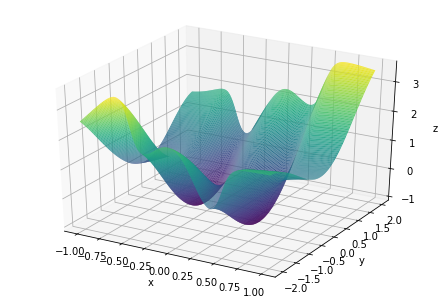

In [13]:
plot(nn)

# Two Block Decomposition MLP

In [78]:
class two_block(Mlp):
    def grad_v(self, params):

        w, b, v = self.w,self.b,self.v
        z = w @ self.X - b
        f_x = self.predict(self.X, w, b, v)
        self.dv = 2*self.rho*v + (1/self.X.shape[1]) * (f_x-y_train) @ self.g(z).T
        return self.dv

    
    def grad_w_b(self, params):
        
        w, b = self.separate_w_b(params)
        v = self.v
        z = w @ self.X - b
        f_x = self.predict(self.X, w, b, v)
        self.dw = 2*self.rho*w + (1/self.X.shape[1]) * (((v.T @ (f_x-self.y)) * self.g_der(z)) @ X_train.T)
        self.db = 2*self.rho*b + ((v.T @ (f_x-self.y)) * self.g_der(z)) * -1
        self.db =(1/self.X.shape[1]) *  np.sum(self.db, axis = 1, keepdims = True)
        self.d_w_b = np.concatenate([array.reshape(-1) for array in [self.dw, self.db]])
        return self.d_w_b
    def separate_w_b(self, l):
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(2)]))
        w, b = [np.array(sliced[i]).reshape(shapes[i]) for i in range(2)]
        return w, b
    def inits(self):
        return np.concatenate([array.reshape(-1) for array in [self.w, self.b, self.v]])

    
    def loss_v(self, v):
        return 0.5 * np.mean(np.square((self.predict(self.X, self.w, self.b, v) - self.y))) +\
        self.rho*np.square(np.linalg.norm(np.concatenate([array.reshape(-1) for array in [self.w, self.b, v]])))
    
    
    def loss_w_b(self,wb):
        w,b = self.separate_w_b(wb)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, self.v) - self.y))) +\
        self.rho*np.square(np.linalg.norm(np.concatenate([array.reshape(-1) for array in [w, b, self.v]])))
    
    
    def optimizer_1(self):
        inits = np.concatenate([array.reshape(-1) for array in [self.w, self.b, self.v]])
        self.grad(self.inits())
        bound_1 = .001
        bound_2 = .001
        theta = .95
        i = 0
        wb = np.concatenate([array.reshape(-1) for array in [self.w, self.b]])        
        while  i < 50:
            #Block 1
            print("begin iteration ",i)
            print("begin block 1")
            min_v = minimize(self.loss_v,x0 = self.v,method = self.method).x
            self.v = min_v.reshape(1,100)
            bound_1 = bound_1 * theta
            print("opt_v ...done")
            if np.linalg.norm(self.grad_v(self.v)) >= bound_1:
                break
            #Block 2
            print("begin block 2")
            min_w_b = minimize(self.loss_w_b,x0 = wb, method = self.method,jac = self.grad_w_b).x
            self.w,self.b = self.separate_w_b(min_w_b)
            wb = np.concatenate([array.reshape(-1) for array in [self.w, self.b]])
            print("opt_w_b ...done")
            if np.linalg.norm(self.grad_w_b(wb)) >= bound_2:
                break
            bound_2 = bound_2 * theta
            i += 1
            print("round ",i," finished with ||grad_v||: ",np.linalg.norm(self.grad_v(self.v)),"epsilon_1 = ",\
                  bound_1,"\n and ||grad_w_b||: ",np.linalg.norm(self.grad_w_b(wb)),"epsilon_2 = ",bound_2,"\n",\
                 "training_error", self.mse(self.X,self.y,self.w,self.b,self.v))
        print("training_error", self.mse(self.X,self.y,self.w,self.b,self.v))

In [79]:
testing_nn = two_block(X_train, y_train, N = 100, sigma = 5, rho = 10e-5, method = "BFGS")

In [ ]:
testing_nn.optimizer_1()

begin iteration  0
begin block 1
opt_v ...done
begin block 2
opt_w_b ...done
round  1  finished with ||grad_v||:  0.001016993798700499 epsilon_1 =  0.00095 
 and ||grad_w_b||:  3.083789482405106e-05 epsilon_2 =  0.00095 
 training_error 0.0004414247003804628
begin iteration  1
begin block 1
opt_v ...done
begin block 2
opt_w_b ...done
round  2  finished with ||grad_v||:  0.0009175437441478301 epsilon_1 =  0.0009025 
 and ||grad_w_b||:  2.427170538743975e-05 epsilon_2 =  0.0009025 
 training_error 0.00046219860839716146
begin iteration  2
begin block 1
opt_v ...done
begin block 2
opt_w_b ...done
round  3  finished with ||grad_v||:  0.0008790015081537151 epsilon_1 =  0.000857375 
 and ||grad_w_b||:  2.208201200639481e-05 epsilon_2 =  0.000857375 
 training_error 0.0004674605880606279
begin iteration  3
begin block 1
opt_v ...done
begin block 2
opt_w_b ...done
round  4  finished with ||grad_v||:  0.0008638560031910982 epsilon_1 =  0.0008145062499999999 
 and ||grad_w_b||:  2.13412438478764

In [25]:
wb = np.concatenate([array.reshape(-1) for array in [testing_nn.w, testing_nn.b]])
minimize(self.loss_w_b,x0 = wb, method = self.method,jac = self.grad_w_b).x

1.9729856275664876e-05 0.0008519450295624614


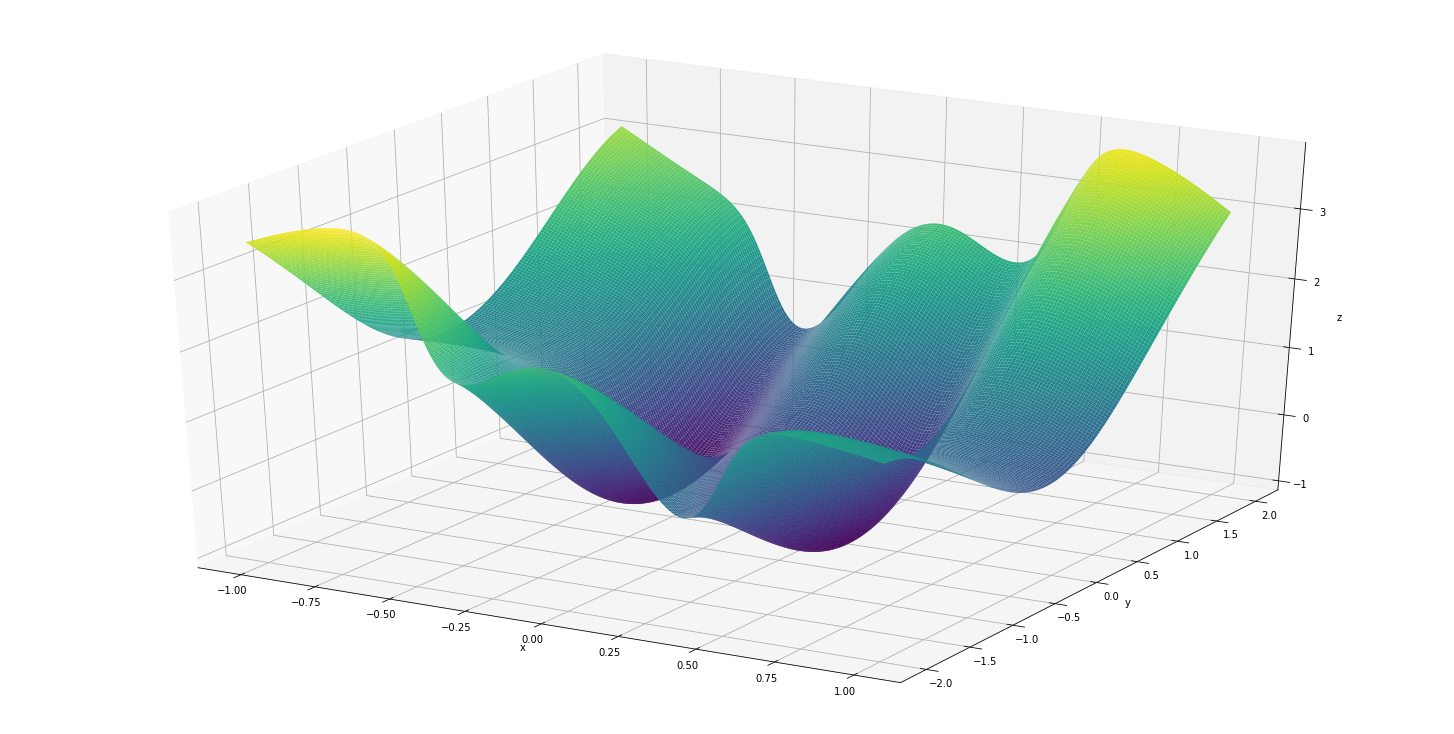

In [22]:
plot(testing_nn)